#TASK 3 **Customer Segmentation / Clustering**
Perform customer segmentation using clustering techniques. Use both profile information
(from Customers.csv) and transaction information (from Transactions.csv).
● You have the flexibility to choose any clustering algorithm and any number of clusters in
between(2 and 10)
● Calculate clustering metrics, including the DB Index(Evaluation will be done on this).
● Visualise your clusters using relevant plots.
Deliverables:
● A report on your clustering results, including:
○ The number of clusters formed.
○ DB Index value.
○ Other relevant clustering metrics.
● A Jupyter Notebook/Python script containing your clustering code.

In [331]:
import pandas as pd
import numpy as np
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import davies_bouldin_score, silhouette_score
import matplotlib.pyplot as plt
import seaborn as sns

In [332]:
# Step 1: Load and merge datasets
customers = pd.read_csv('/content/Customers.csv')
transactions = pd.read_csv('/content/Transactions - Transactions.csv')

In [333]:
# Convert date columns to datetime
customers['SignupDate'] = pd.to_datetime(customers['SignupDate'])
transactions['TransactionDate'] = pd.to_datetime(transactions['TransactionDate'])

In [334]:

# Aggregate transaction information for each customer
transaction_summary = transactions.groupby('CustomerID').agg(
    TotalSpending=('TotalValue', 'sum'),
    AvgSpendingPerTransaction=('TotalValue', 'mean'),
    TotalTransactions=('TransactionID', 'count')
).reset_index()

In [335]:

# Merge with customer profile information
customer_data = customers.merge(transaction_summary, on='CustomerID', how='left')
customer_data.fillna(0, inplace=True)  # Fill missing transaction data for customers with no transactions


In [336]:
customer_data.isnull().sum()

,0
CustomerID,0
CustomerName,0
Region,0
SignupDate,0
TotalSpending,0
AvgSpendingPerTransaction,0
TotalTransactions,0


In [337]:

# Encode the 'Region' column (categorical variable)
customer_data = pd.get_dummies(customer_data, columns=['Region'], drop_first=True)


In [338]:

# Feature engineering: Extract signup year for additional segmentation
customer_data['SignupYear'] = customer_data['SignupDate'].dt.year

In [339]:

# Step 2: Select features for clustering
features = ['TotalSpending', 'AvgSpendingPerTransaction', 'TotalTransactions'] + \
           [col for col in customer_data.columns if 'Region_' in col] + ['SignupYear']
X = customer_data[features]


In [340]:

# Standardize features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

#KMEANS ALGO

In [341]:
best_db_index = float('inf')
optimal_k = 0
optimal_labels = None

for k in range(2, 11):  # Experiment with different numbers of clusters
    for random_state in range(42, 52): # Experiment with different random states
        kmeans = KMeans(n_clusters=k, random_state=random_state, n_init=300) # Increased n_init
        cluster_labels = kmeans.fit_predict(X_scaled)
        db_index = davies_bouldin_score(X_scaled, cluster_labels)

        if db_index < best_db_index:
            best_db_index = db_index
            optimal_k = k
            optimal_labels = cluster_labels


print(f"Optimal number of clusters: {optimal_k}")
print(f"Davies-Bouldin Index: {best_db_index}")


Optimal number of clusters: 10
Davies-Bouldin Index: 1.160765545874279


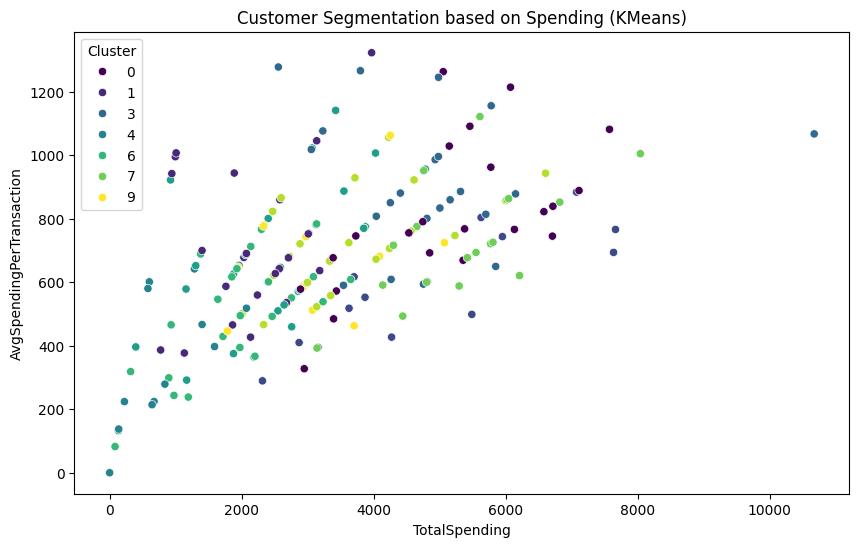

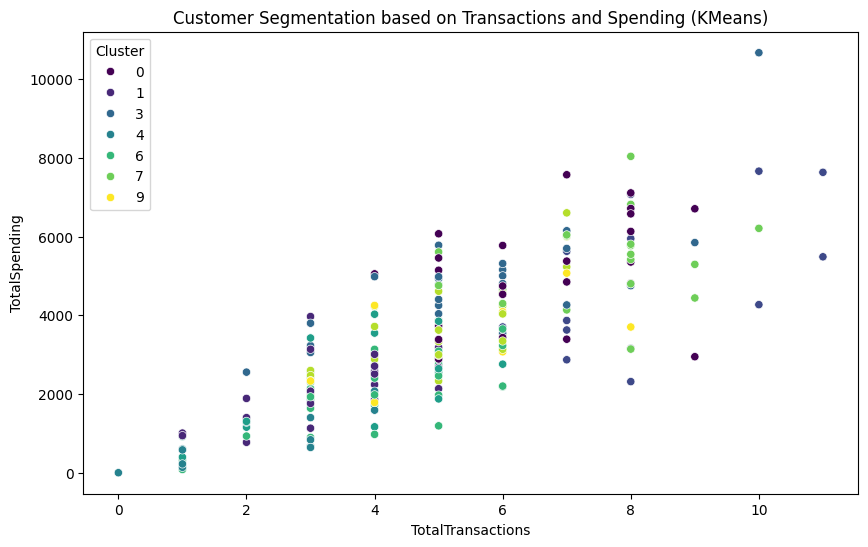

In [342]:
# Assign the optimal cluster labels to the DataFrame
customer_data['Cluster'] = optimal_labels

# Visualize clusters
plt.figure(figsize=(10, 6))
sns.scatterplot(x='TotalSpending', y='AvgSpendingPerTransaction', hue='Cluster', data=customer_data, palette='viridis')
plt.title('Customer Segmentation based on Spending (KMeans)')
plt.show()

plt.figure(figsize=(10, 6))
sns.scatterplot(x='TotalTransactions', y='TotalSpending', hue='Cluster', data=customer_data, palette='viridis')
plt.title('Customer Segmentation based on Transactions and Spending (KMeans)')
plt.show()

#DBSCAN ALGO

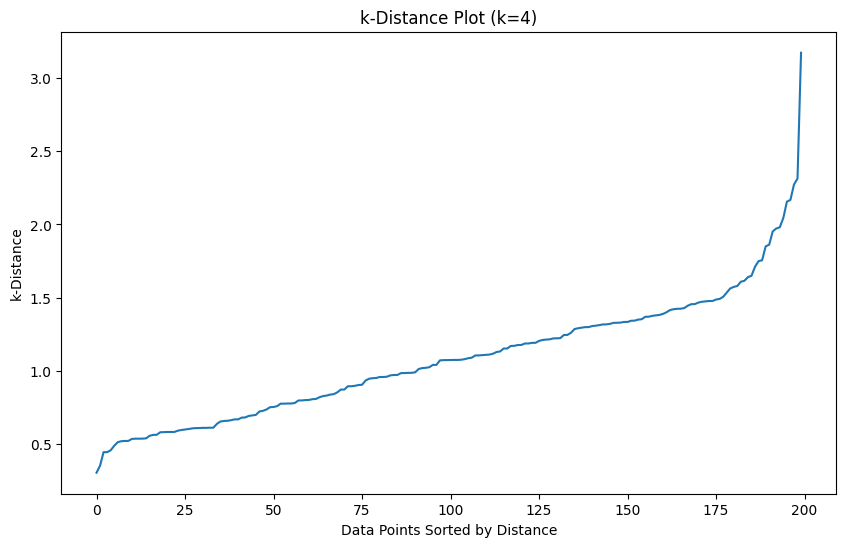

In [343]:
from sklearn.cluster import DBSCAN
from sklearn.metrics import davies_bouldin_score, silhouette_score
from sklearn.neighbors import NearestNeighbors


# Step 1: Compute k-distance plot for eps selection
k = 4  # Choose min_samples value for k-distance
nearest_neighbors = NearestNeighbors(n_neighbors=k)
neighbors = nearest_neighbors.fit(X_scaled)
distances, indices = neighbors.kneighbors(X_scaled)

# Sort distances to find the "elbow" point
distances = np.sort(distances[:, k - 1])
plt.figure(figsize=(10, 6))
plt.plot(distances)
plt.title('k-Distance Plot (k=4)')
plt.xlabel('Data Points Sorted by Distance')
plt.ylabel('k-Distance')
plt.show()

# Step 2: Apply DBSCAN with refined parameters
dbscan_results = []
for eps in np.arange(0.5, 2.1, 0.1):  # Wider range for eps
    for min_samples in range(2, 6):  # Test smaller min_samples
        dbscan = DBSCAN(eps=eps, min_samples=min_samples)
        dbscan_labels = dbscan.fit_predict(X_scaled)

        # Ignore cases where all points are classified as noise
        if len(set(dbscan_labels)) <= 1:
            continue

        # Calculate DB Index for valid clustering
        db_index = davies_bouldin_score(X_scaled, dbscan_labels)
        silhouette_avg = silhouette_score(X_scaled, dbscan_labels)

        dbscan_results.append({
            'eps': eps,
            'min_samples': min_samples,
            'DB Index': db_index,
            'Silhouette Score': silhouette_avg,
            'Clusters': len(set(dbscan_labels)) - (1 if -1 in dbscan_labels else 0)  # Exclude noise
        })

# Step 3: Find the best parameters based on the lowest DB Index
dbscan_results_df = pd.DataFrame(dbscan_results)
best_dbscan = dbscan_results_df.loc[dbscan_results_df['DB Index'].idxmin()]

# Train the final DBSCAN model with the best parameters
optimal_eps = best_dbscan['eps']
optimal_min_samples = best_dbscan['min_samples']
dbscan = DBSCAN(eps=optimal_eps, min_samples=int(optimal_min_samples))
customer_data['Cluster_DBSCAN'] = dbscan.fit_predict(X_scaled)


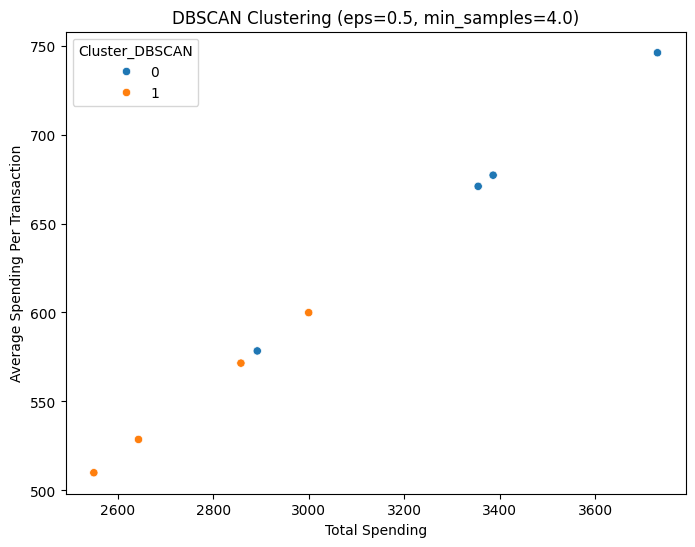

Optimal eps: 0.5
Optimal min_samples: 4.0
DB Index: 1.241536574614803
Silhouette Score: -0.18992767921115777
Number of clusters (excluding noise): 2.0


In [344]:
# Step 4: Visualize results
valid_clusters = customer_data[customer_data['Cluster_DBSCAN'] != -1]  # Exclude noise
plt.figure(figsize=(8, 6))
sns.scatterplot(
    x=valid_clusters['TotalSpending'],
    y=valid_clusters['AvgSpendingPerTransaction'],
    hue=valid_clusters['Cluster_DBSCAN'],
    palette='tab10',
    legend='full'
)
plt.title(f'DBSCAN Clustering (eps={optimal_eps}, min_samples={optimal_min_samples})')
plt.xlabel('Total Spending')
plt.ylabel('Average Spending Per Transaction')
plt.show()

# Step 5: Print results
print("Optimal eps:", optimal_eps)
print("Optimal min_samples:", optimal_min_samples)
print("DB Index:", best_dbscan['DB Index'])
print("Silhouette Score:", best_dbscan['Silhouette Score'])
print("Number of clusters (excluding noise):", best_dbscan['Clusters'])


#GMMS

In [345]:

from sklearn.mixture import GaussianMixture

In [346]:
# Step 3: Apply Gaussian Mixture Models (GMM)
# Test different numbers of clusters (from 2 to 10)
cluster_metrics = []
for k in range(2, 11):
    gmm = GaussianMixture(n_components=k, random_state=42)
    gmm_labels = gmm.fit_predict(X_scaled)

    # Calculate Davies-Bouldin Index
    db_index = davies_bouldin_score(X_scaled, gmm_labels)
    # Calculate Silhouette Score
    silhouette_avg = silhouette_score(X_scaled, gmm_labels)

    cluster_metrics.append({'Clusters': k, 'DB Index': db_index, 'Silhouette Score': silhouette_avg})

# Convert metrics to DataFrame
metrics_df = pd.DataFrame(cluster_metrics)

# Identify the optimal number of clusters based on the lowest DB Index
optimal_k = metrics_df.loc[metrics_df['DB Index'].idxmin(), 'Clusters']


In [347]:
db_index

1.322959236742997

In [348]:
optimal_k

10

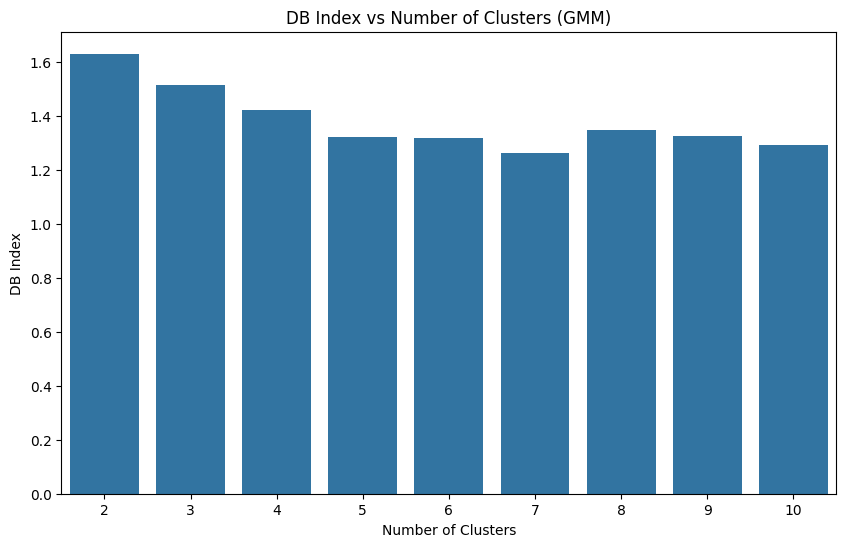

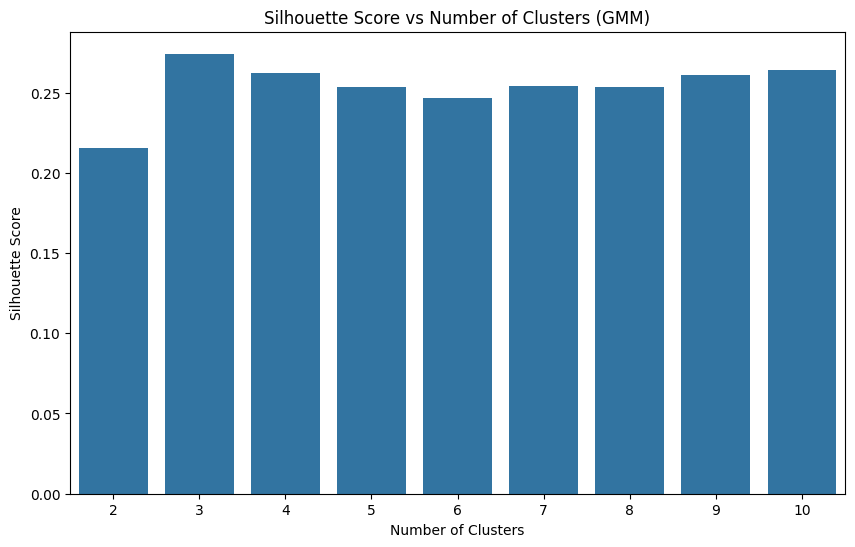

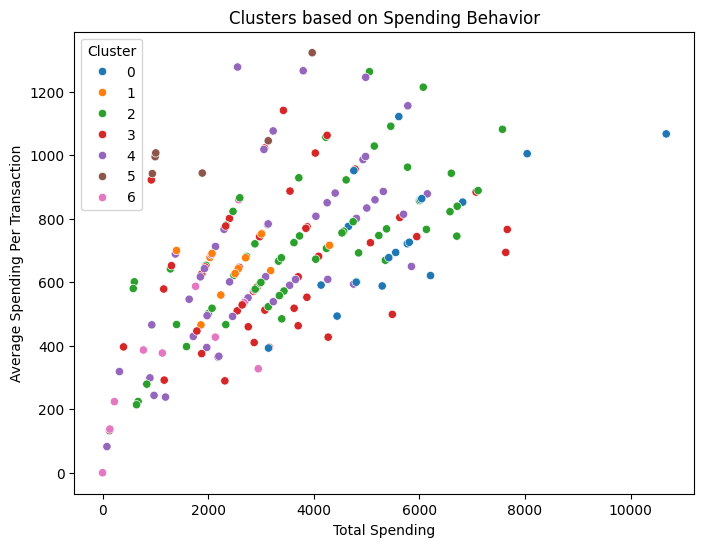

Number of clusters formed: 7
DB Index for optimal clustering: 1.2634192667866453
Silhouette Score for optimal clustering: 0.25410915018650754


In [355]:

# Train the final GMM model with the optimal number of clusters
final_gmm = GaussianMixture(n_components=optimal_k, random_state=42)
customer_data['Cluster'] = final_gmm.fit_predict(X_scaled)

# Step 4: Visualize clustering metrics
plt.figure(figsize=(10, 6))
sns.barplot(x='Clusters', y='DB Index', data=metrics_df)
plt.title('DB Index vs Number of Clusters (GMM)')
plt.xlabel('Number of Clusters')
plt.ylabel('DB Index')
plt.show()

plt.figure(figsize=(10, 6))
sns.barplot(x='Clusters', y='Silhouette Score', data=metrics_df)
plt.title('Silhouette Score vs Number of Clusters (GMM)')
plt.xlabel('Number of Clusters')
plt.ylabel('Silhouette Score')
plt.show()

# Step 5: Visualize cluster distribution
plt.figure(figsize=(8, 6))
sns.scatterplot(
    x=customer_data['TotalSpending'],
    y=customer_data['AvgSpendingPerTransaction'],
    hue=customer_data['Cluster'],
    palette='tab10',
    legend='full'
)
plt.title('Clusters based on Spending Behavior')
plt.xlabel('Total Spending')
plt.ylabel('Average Spending Per Transaction')
plt.show()


# Print final results
print("Number of clusters formed:", optimal_k)
print("DB Index for optimal clustering:", metrics_df.loc[metrics_df['Clusters'] == optimal_k, 'DB Index'].values[0])
print("Silhouette Score for optimal clustering:", metrics_df.loc[metrics_df['Clusters'] == optimal_k, 'Silhouette Score'].values[0])



# Hierarchical Clustering (Agglomerative)

In [350]:

from sklearn.cluster import AgglomerativeClustering
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import davies_bouldin_score, silhouette_score
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.cluster.hierarchy import dendrogram, linkage

In [351]:

# Step 3: Perform Agglomerative Clustering
# Test clustering for 2 to 10 clusters
cluster_metrics = []
for k in range(2, 11):
    agglo = AgglomerativeClustering(n_clusters=k, linkage='ward')
    cluster_labels = agglo.fit_predict(X_scaled)

    # Calculate Davies-Bouldin Index
    db_index = davies_bouldin_score(X_scaled, cluster_labels)
    # Calculate Silhouette Score
    silhouette_avg = silhouette_score(X_scaled, cluster_labels)

    cluster_metrics.append({'Clusters': k, 'DB Index': db_index, 'Silhouette Score': silhouette_avg})

# Convert metrics to DataFrame
metrics_df = pd.DataFrame(cluster_metrics)

# Identify the optimal number of clusters based on the lowest DB Index
optimal_k = metrics_df.loc[metrics_df['DB Index'].idxmin(), 'Clusters']


In [352]:
optimal_k

7

In [353]:
db_index

1.2922731507768208

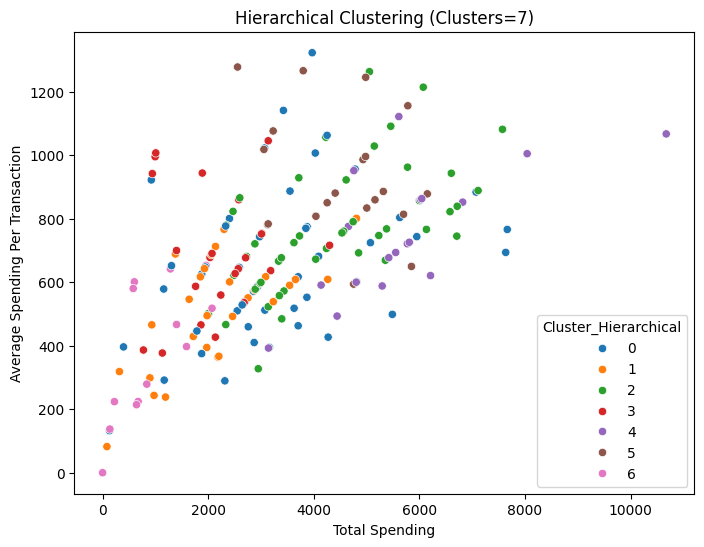

Number of clusters formed: 7
DB Index for optimal clustering: 1.2634192667866453
Silhouette Score for optimal clustering: 0.25410915018650754


In [354]:

# Train the final model with the optimal number of clusters
final_model = AgglomerativeClustering(n_clusters=optimal_k, linkage='ward')
customer_data['Cluster_Hierarchical'] = final_model.fit_predict(X_scaled)

# Visualize clusters
plt.figure(figsize=(8, 6))
sns.scatterplot(
    x=customer_data['TotalSpending'],
    y=customer_data['AvgSpendingPerTransaction'],
    hue=customer_data['Cluster_Hierarchical'],
    palette='tab10',
    legend='full'
)
plt.title(f'Hierarchical Clustering (Clusters={optimal_k})')
plt.xlabel('Total Spending')
plt.ylabel('Average Spending Per Transaction')
plt.show()

# Print results
print("Number of clusters formed:", optimal_k)
print("DB Index for optimal clustering:", metrics_df.loc[metrics_df['Clusters'] == optimal_k, 'DB Index'].values[0])
print("Silhouette Score for optimal clustering:", metrics_df.loc[metrics_df['Clusters'] == optimal_k, 'Silhouette Score'].values[0])
